In [1]:
import random
import sys
from collections import defaultdict
from pathlib import Path

import cv2
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm

# Ensure outer package root on path so flattened single-level imports work
proj_root = Path.cwd()
outer_pkg_root = proj_root / "intrinsic_camera_calibrator"
if str(outer_pkg_root) not in sys.path:
    sys.path.append(str(outer_pkg_root))

# Single-level imports (flattened via outer __init__.py)

# Indices for cameras
LEFT, RIGHT = 0, 1

# Unified container for per‑camera data (flattened)
cam = {
    "objpoints": [[], []],  # 3D object points per camera
    "imgpoints": [[], []],  # 2D image points per camera
    "K": [None, None],
    "dist": [None, None],
    "R": [None, None],  # rectification rotations
    "P": [None, None],  # projection matrices
    "map1": [None, None],  # rectification map x
    "map2": [None, None],  # rectification map y
}


In [2]:
# Prefer pathlib.glob and handle notebooks where __file__ may be undefined
base = Path(__file__).resolve().parent if "__file__" in globals() else Path.cwd()
raw_data_folder = base / "data" / "34759_final_project_raw"

images_left = sorted((raw_data_folder / "calib" / "image_02" / "data").glob("*.png"))
images_right = sorted((raw_data_folder / "calib" / "image_03" / "data").glob("*.png"))
# images_left = sorted((raw_data_folder / "calib" / "image_02" / "data").glob("*00.png"))
# images_right = sorted((raw_data_folder / "calib" / "image_03" / "data").glob("*00.png"))

# convert to strings for cv2.imread if needed
images_left = [str(p) for p in images_left]
images_right = [str(p) for p in images_right]

assert len(images_left) and len(images_right), "Missing calibration images for one or both cameras"

# Chessboard corners

In [3]:
def find_all_chessboards(gray, pattern_sizes, max_boards=10):
    all_corners = []
    all_objp = []
    all_pattern_sizes = []
    work = gray.copy()
    flags_normal = (
        cv2.CALIB_CB_ADAPTIVE_THRESH | cv2.CALIB_CB_NORMALIZE_IMAGE | cv2.CALIB_CB_FAST_CHECK
        # | cv2.CALIB_CB_FILTER_QUADS
    )
    flags_SB = (
        cv2.CALIB_CB_EXHAUSTIVE | cv2.CALIB_CB_NORMALIZE_IMAGE | cv2.CALIB_CB_ACCURACY
        # cv2.CALIB_CB_LARGER
    )
    # Use SB variant if available for robustness:
    # use_sb = hasattr(cv2, "findChessboardCornersSB")
    # use_sb = False
    avg_color = np.average(gray)

    # Note: pattern_sizes should be an ordered iterable (list/tuple), not a set, for reproducibility
    for nb_vert, nb_horiz in pattern_sizes:
        for _ in range(max_boards):
            ret, corners = cv2.findChessboardCornersSB(work, (nb_vert, nb_horiz), flags=flags_SB)
            use_sb = True
            if not ret:
                ret, corners = cv2.findChessboardCorners(work, (nb_vert, nb_horiz), flags=flags_normal)
                use_sb = False

            if not ret:
                break

            # prepare object points: (x, y, 0) grid
            objp = np.zeros((nb_horiz * nb_vert, 3), np.float32)
            objp[:, :2] = np.mgrid[0:nb_vert, 0:nb_horiz].T.reshape(-1, 2)
            all_objp.append(objp)
            all_pattern_sizes.append((nb_vert, nb_horiz))

            # Subpixel refine on original gray only if not using SB (SB is already subpixel-accurate)
            if use_sb:
                # Ensure float32 shape for downstream consumers
                corners_ref = corners.astype(np.float32, copy=False)
            else:
                # Ensure correct dtype and contiguous layout
                corners = corners.astype(np.float32, copy=False)
                # Determine a reasonable subpixel window from the detected board bbox
                x, y, w, h = cv2.boundingRect(corners)
                # Estimate checker square size (in pixels) along both axes
                sq_w = max(1.0, w / max(1, (nb_vert - 1)))
                sq_h = max(1.0, h / max(1, (nb_horiz - 1)))
                # Pick a conservative window ~ 1/4 square size, clamped
                auto_win = int(max(3, min(15, 0.25 * min(sq_w, sq_h))))
                win = (auto_win, auto_win)
                # Termination criteria
                term = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 1e-3)
                # cornerSubPix modifies the array in-place in many OpenCV builds
                corners = cv2.cornerSubPix(gray, corners, win, (-1, -1), term)
                corners_ref = corners

            all_corners.append(corners_ref)

            # Mask out detected board region (expand a bit) to find the next one
            x, y, w, h = cv2.boundingRect(corners_ref)
            pad = 10
            x0, y0 = max(0, x - pad), max(0, y - pad)
            x1, y1 = min(work.shape[1], x + w + pad), min(work.shape[0], y + h + pad)
            cv2.rectangle(work, (x0, y0), (x1, y1), color=avg_color, thickness=-1)

    return all_corners, all_objp, all_pattern_sizes

In [4]:
pattern_sizes = [(11, 7), (15, 5), (7, 5)]  # (nb of vert pnts, nb of horiz pnts)

# Criteria for corner refinement
criteria = (cv2.TermCriteria_EPS + cv2.TermCriteria_MAX_ITER, 100, 0.001)

for idx, image_list in enumerate([images_left, images_right]):
    for fname in image_list:
        img = cv2.imread(fname)
        if img is None:
            continue
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        corners_sets, objp_list, pattern_sizes_list = find_all_chessboards(gray, pattern_sizes)

        for corners, objp, (nb_vertical, nb_horizontal) in zip(
            corners_sets, objp_list, pattern_sizes_list, strict=False
        ):
            cam["imgpoints"][idx].append(corners)
            cam["objpoints"][idx].append(objp)
#             vis = cv2.drawChessboardCorners(img.copy(), (nb_vertical, nb_horizontal), corners, True)
#             cv2.imshow("Corners", vis)
#             cv2.waitKey(0)

# cv2.destroyAllWindows()

In [10]:
nb_imgp = []
nb_objp = []
for i in range(len(cam["imgpoints"])):
    nb_imgp.append(len(cam["imgpoints"][i]))
    nb_objp.append(len(cam["objpoints"][i]))

nb_imgp, nb_objp

([247, 209], [247, 209])

In [12]:
len(cam["objpoints"][:])

2

# Intrinsic Calibration

In [14]:
# Calibrate LEFT camera (compact assignment)
_, cam["K"][LEFT], cam["dist"][LEFT], _, _ = cv2.calibrateCamera(
    cam["objpoints"][LEFT], cam["imgpoints"][LEFT], gray.shape[::-1], None, None
)

img_left = cv2.imread(random.choice(images_left))
h, w = img_left.shape[:2]
newcameramtx_left, roi_left = cv2.getOptimalNewCameraMatrix(cam["K"][LEFT], cam["dist"][LEFT], (w, h), 1, (w, h))
cam["K"][LEFT], cam["dist"][LEFT]

(array([[1.14751436e+03, 0.00000000e+00, 6.90395628e+02],
        [0.00000000e+00, 1.06028363e+03, 2.55787162e+02],
        [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]]),
 array([[-1.75043455e-01, -4.00691843e-01,  4.22219977e-04,
         -1.30040440e-02,  5.42996555e-01]]))

In [ ]:
# Calibrate RIGHT camera (compact assignment)
_, cam["K"][RIGHT], cam["dist"][RIGHT], _, _ = cv2.calibrateCamera(
    cam["objpoints"][RIGHT], cam["imgpoints"][RIGHT], gray.shape[::-1], None, None
)

img_right = cv2.imread(random.choice(images_right))
h, w = img_right.shape[:2]
newcameramtx_right, roi_right = cv2.getOptimalNewCameraMatrix(cam["K"][RIGHT], cam["dist"][RIGHT], (w, h), 1, (w, h))
cam["K"][RIGHT], cam["dist"][RIGHT]

(array([[935.05019314,   0.        , 702.2161443 ],
        [  0.        , 938.96834432, 255.39856915],
        [  0.        ,   0.        ,   1.        ]]),
 array([[-3.86845951e-01,  3.00939551e-01, -3.80738367e-04,
         -2.01769619e-03, -1.67331545e-01]]))

In [ ]:
# Robust intrinsic calibration utilities (pre-rejection + RANSAC + post-rejection) WITH progress bars
import math
from statistics import median

# Try to import tqdm for progress bars; provide graceful fallback
try:
    from tqdm.auto import tqdm
except ImportError:  # minimal fallback

    def tqdm(iterable=None, **kwargs):
        return iterable if iterable is not None else []


def _standardize_points(obj_list, img_list):
    o_list = [np.asarray(o, dtype=np.float32).reshape(-1, 3) for o in obj_list]
    i_list = [np.asarray(i, dtype=np.float32).reshape(-1, 1, 2) for i in img_list]
    return o_list, i_list


def _errors_with_model(K, dist, obj_list, img_list, progress=False, desc="Errors"):
    errs = []
    iterable = zip(obj_list, img_list, strict=False)
    if progress and len(obj_list) > 6:
        iterable = tqdm(iterable, total=len(obj_list), desc=desc)
    for o, i in iterable:
        # Solve extrinsic for this board using PnP with current intrinsics
        ok, rvec, tvec = cv2.solvePnP(o, i.reshape(-1, 2), K, dist, flags=cv2.SOLVEPNP_ITERATIVE)
        if not ok:
            rvec = np.zeros((3, 1))
            tvec = np.zeros((3, 1))
        proj, _ = cv2.projectPoints(o, rvec, tvec, K, dist)
        e = np.linalg.norm(proj.reshape(-1, 2) - i.reshape(-1, 2), axis=1)
        errs.append(float(np.sqrt(np.mean(e * e))))
    return np.array(errs, dtype=np.float64)


def _adaptive_threshold(errors, scale=1.5):
    if len(errors) == 0:
        return 0.0
    med = float(median(errors))
    q1 = np.percentile(errors, 25)
    q3 = np.percentile(errors, 75)
    iqr = q3 - q1
    base = iqr if iqr > 0 else (med * 0.5 + 1e-6)
    return med + scale * base


def calibrate_intrinsics_robust(
    objpoints_list,
    imgpoints_list,
    image_size,
    pre_rejection=True,
    ransac_iterations=150,
    subset_ratio=0.5,
    post_rejection=True,
    verbose=True,
    progress=True,
):
    """Robust camera intrinsic calibration with optional progress bars.
    Steps:
      1. Standardize input points.
      2. Naive full-set calibration -> baseline RMS.
      3. Pre-rejection: remove outlier boards by per-board RMS (median + 1.5*IQR).
      4. RANSAC-style intrinsic search: random subsets -> candidate intrinsics; evaluate inlier set by threshold.
      5. Post-rejection: tighter pruning (scale=1.0) and final calibration on remaining boards.
    Returns summary dict.
    """
    if len(objpoints_list) < 4:
        raise ValueError("Need at least 4 board detections for robust calibration")

    obj_all, img_all = _standardize_points(objpoints_list, imgpoints_list)

    if verbose:
        print("[Stage 1] Naive calibration")
    _, K0, dist0, _, _ = cv2.calibrateCamera(obj_all, img_all, image_size, None, None)
    naive_errors = _errors_with_model(K0, dist0, obj_all, img_all, progress=progress, desc="Naive per-board RMS")
    rms_naive = float(np.sqrt(np.mean(naive_errors**2)))

    # Pre-rejection phase
    pre_mask = np.ones(len(obj_all), dtype=bool)
    removed_pre = 0
    if pre_rejection and len(obj_all) > 6:
        if verbose:
            print("[Stage 2] Pre-rejection filtering")
        thr_pre = _adaptive_threshold(naive_errors, scale=1.5)
        pre_mask = naive_errors <= thr_pre
        if pre_mask.sum() < 4:
            pre_mask[:] = True  # keep enough points
        removed_pre = int((~pre_mask).sum())
        if verbose:
            print(f"Pre-rejection: thr={thr_pre:.3f} removed={removed_pre}")

    pre_obj = [o for o, m in zip(obj_all, pre_mask, strict=False) if m]
    pre_img = [i for i, m in zip(img_all, pre_mask, strict=False) if m]

    # RANSAC-like intrinsic search
    subset_size = max(4, int(len(pre_obj) * subset_ratio))
    subset_size = min(subset_size, len(pre_obj))
    rng = np.random.default_rng(2025)
    best = None  # (K, dist, inlier_mask, score, count)
    if verbose:
        print("[Stage 3] RANSAC search over intrinsic subsets")
        print(f"RANSAC: iters={ransac_iterations} subset_size={subset_size} candidates={len(pre_obj)}")

    r_iter = range(ransac_iterations)
    if progress and ransac_iterations > 10:
        r_iter = tqdm(r_iter, desc="RANSAC", total=ransac_iterations)

    for it in r_iter:
        subset_idx = rng.choice(len(pre_obj), size=subset_size, replace=False)
        obj_subset = [pre_obj[j] for j in subset_idx]
        img_subset = [pre_img[j] for j in subset_idx]
        _, K_c, dist_c, _, _ = cv2.calibrateCamera(obj_subset, img_subset, image_size, None, None)
        errs_all = _errors_with_model(K_c, dist_c, pre_obj, pre_img, progress=False)
        thr_ransac = _adaptive_threshold(errs_all, scale=1.2)
        inlier_mask = errs_all <= thr_ransac
        inlier_count = int(inlier_mask.sum())
        score = float(np.sqrt(np.mean(errs_all[inlier_mask] ** 2))) if inlier_count else math.inf
        if best is None:
            best = (K_c, dist_c, inlier_mask, score, inlier_count)
        else:
            _, _, _, best_score, best_count = best
            if (inlier_count > best_count) or (inlier_count == best_count and score < best_score):
                best = (K_c, dist_c, inlier_mask, score, inlier_count)

    if best is None:
        raise RuntimeError("RANSAC failed to produce a candidate model")

    K_best, dist_best, inlier_mask_best, score_best, count_best = best
    if verbose:
        print(f"RANSAC best: inliers={count_best}/{len(pre_obj)} RMS_inliers={score_best:.3f}")

    inlier_obj = [pre_obj[i] for i, m in enumerate(inlier_mask_best) if m]
    inlier_img = [pre_img[i] for i, m in enumerate(inlier_mask_best) if m]

    # Post-rejection tightening
    removed_post = 0
    if post_rejection and len(inlier_obj) > 6:
        if verbose:
            print("[Stage 4] Post-rejection tightening")
        errs_inliers = _errors_with_model(K_best, dist_best, inlier_obj, inlier_img, progress=progress, desc="Post RMS")
        thr_post = _adaptive_threshold(errs_inliers, scale=1.0)
        post_mask = errs_inliers <= thr_post
        if post_mask.sum() >= 4:
            removed_post = int((~post_mask).sum())
            inlier_obj = [o for o, m in zip(inlier_obj, post_mask, strict=False) if m]
            inlier_img = [i for i, m in zip(inlier_img, post_mask, strict=False) if m]
            if verbose:
                print(f"Post-rejection: thr={thr_post:.3f} removed={removed_post}")

    if verbose:
        print("[Stage 5] Final calibration")
    _, K_f, dist_f, _, _ = cv2.calibrateCamera(inlier_obj, inlier_img, image_size, None, None)
    final_errors = _errors_with_model(K_f, dist_f, inlier_obj, inlier_img, progress=progress, desc="Final RMS")
    rms_final = float(np.sqrt(np.mean(final_errors**2)))

    return {
        "K": K_f,
        "dist": dist_f,
        "rms_final": rms_final,
        "rms_naive": rms_naive,
        "inliers_count": len(inlier_obj),
        "total_detections": len(obj_all),
        "removed_pre": removed_pre,
        "removed_post": removed_post,
    }


print("Robust intrinsic calibration utilities loaded (PnP-based errors, tqdm progress).")

Robust intrinsic calibration utilities loaded (PnP-based errors).


In [ ]:
# Execute robust calibration for LEFT and RIGHT cameras
# Ensure prerequisite variables: cam, images_left/right, gray or image size.

if "gray" in globals():
    image_size = (gray.shape[1], gray.shape[0])
else:
    tmp_img = cv2.imread(images_left[0])
    image_size = (tmp_img.shape[1], tmp_img.shape[0])

results = {}
for cam_idx, name in [(LEFT, "LEFT"), (RIGHT, "RIGHT")]:
    obj_list = cam["objpoints"][cam_idx]
    img_list = cam["imgpoints"][cam_idx]
    if len(obj_list) == 0:
        print(f"Skipping {name}: no detections.")
        continue
    res = calibrate_intrinsics_robust(
        obj_list,
        img_list,
        image_size,
        pre_rejection=True,
        ransac_iterations=200,
        subset_ratio=0.6,
        post_rejection=True,
        verbose=True,
    )
    cam["K"][cam_idx] = res["K"]
    cam["dist"][cam_idx] = res["dist"]
    results[name] = res
    print(
        f"\n{name} robust calibration summary:\n"
        f"  Total detections   : {res['total_detections']}\n"
        f"  Removed pre        : {res['removed_pre']}\n"
        f"  Inliers after RANSAC/post: {res['inliers_count']}\n"
        f"  RMS naive          : {res['rms_naive']:.4f} px\n"
        f"  RMS final          : {res['rms_final']:.4f} px\n"
        f"  Improvement (naive-final): {res['rms_naive'] - res['rms_final']:.4f} px"
    )

# Quick visual sanity: undistort one random image per side
for cam_idx, name, img_pool in [(LEFT, "LEFT", images_left), (RIGHT, "RIGHT", images_right)]:
    if cam["K"][cam_idx] is None:
        continue
    test_img = cv2.imread(random.choice(img_pool))
    if test_img is None:
        continue
    und = cv2.undistort(test_img, cam["K"][cam_idx], cam["dist"][cam_idx])
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    ax[0].imshow(test_img[..., ::-1])
    ax[0].set_title(f"{name} Original")
    ax[0].axis("off")
    ax[1].imshow(und[..., ::-1])
    ax[1].set_title(f"{name} Undistorted")
    ax[1].axis("off")
    plt.show()

print("Robust calibration completed for available cameras.")

In [ ]:
cam["K"][LEFT], cam["dist"][LEFT], cam["K"][RIGHT], cam["dist"][RIGHT]

# Rectification

In [ ]:
def _centroid_and_bbox(corners: np.ndarray):
    pts = corners.reshape(-1, 2)
    c = pts.mean(axis=0)  # (x, y)
    x, y, w, h = cv2.boundingRect(corners.astype(np.float32))
    return c, (w, h)


def match_chessboards(dets_left, dets_right, dy_thresh=8.0, scale_ratio_thresh=0.25):
    """
    Match chessboard detections between left and right images.

    dets_left/dets_right: list of tuples (corners, (nb_vert, nb_horiz))
    Returns: matches, unmatched_left, unmatched_right
      - matches: list of (idx_left, idx_right)
      - unmatched_left: list of indices in dets_left with no match
      - unmatched_right: list of indices in dets_right with no match

    Strategy:
      - Group by pattern size to avoid cross-size matches
      - For each size group, greedily associate by minimal vertical distance (|yL - yR|)
        with additional scale consistency gating using bbox height similarity.
    """
    # Group detections by pattern size
    left_groups = defaultdict(list)
    right_groups = defaultdict(list)
    for i, (_, sz) in enumerate(dets_left):
        left_groups[tuple(sz)].append(i)
    for j, (_, sz) in enumerate(dets_right):
        right_groups[tuple(sz)].append(j)

    all_sizes = set(left_groups.keys()) | set(right_groups.keys())

    matches = []
    unmatched_left = []
    unmatched_right = []

    for sz in all_sizes:
        L = left_groups.get(sz, [])
        R = right_groups.get(sz, [])
        if not L:
            unmatched_right.extend(R)
            continue
        if not R:
            unmatched_left.extend(L)
            continue

        # Precompute features
        L_feats = {}
        for i in L:
            c, (w, h) = _centroid_and_bbox(dets_left[i][0])
            L_feats[i] = (c, (w, h))
        R_feats = {}
        for j in R:
            c, (w, h) = _centroid_and_bbox(dets_right[j][0])
            R_feats[j] = (c, (w, h))

        used_R = set()
        # Greedy match: iterate left by increasing y
        for i in sorted(L, key=lambda k: L_feats[k][0][1]):
            cL, (wL, hL) = L_feats[i]
            best_j = None
            best_cost = float("inf")
            for j in R:
                if j in used_R:
                    continue
                cR, (wR, hR) = R_feats[j]
                dy = abs(float(cL[1]) - float(cR[1]))
                # Relative height similarity (acts as proxy for distance/scale)
                h_max = max(1.0, float(max(hL, hR)))
                scale_rel = abs(float(hL) - float(hR)) / h_max
                if dy > dy_thresh or scale_rel > scale_ratio_thresh:
                    continue
                # Cost prioritizes vertical alignment; scale acts as tiebreaker
                cost = dy + 0.25 * abs(float(hL) - float(hR))
                if cost < best_cost:
                    best_cost = cost
                    best_j = j
            if best_j is not None:
                matches.append((i, best_j))
                used_R.add(best_j)
            else:
                unmatched_left.append(i)
        # Any remaining right detections are unmatched
        unmatched_right.extend([j for j in R if j not in used_R])

    return matches, unmatched_left, unmatched_right

In [ ]:
# Detect per stereo pair and build matched stereo sets
square_size = 0.1  # meters (or any consistent unit)

stereo = {
    "objpoints": [],
    "imgpoints_left": [],
    "imgpoints_right": [],
}

pair_count = min(len(images_left), len(images_right))
print(f"Processing {pair_count} stereo pairs for matching…")

for k in range(pair_count):
    fnameL, fnameR = images_left[k], images_right[k]
    imgL = cv2.imread(fnameL)
    imgR = cv2.imread(fnameR)
    if imgL is None or imgR is None:
        print(f"Skipping pair {k}: read error")
        continue
    grayL = cv2.cvtColor(imgL, cv2.COLOR_BGR2GRAY)
    grayR = cv2.cvtColor(imgR, cv2.COLOR_BGR2GRAY)

    # Run multi-board detection on each side
    corners_L, objps_L, sizes_L = find_all_chessboards(grayL, pattern_sizes)
    corners_R, objps_R, sizes_R = find_all_chessboards(grayR, pattern_sizes)

    # Pack detections as (corners, (nb_vert, nb_horiz))
    dets_L = list(zip(corners_L, sizes_L, strict=False))
    dets_R = list(zip(corners_R, sizes_R, strict=False))

    matches, uL, uR = match_chessboards(dets_L, dets_R, dy_thresh=8.0, scale_ratio_thresh=0.25)

    # Build stereo lists from matches
    matched_this_pair = 0
    for iL, iR in matches:
        cornersL, size = dets_L[iL]
        cornersR, sizeR = dets_R[iR]
        # Plausibility: pattern sizes must agree exactly
        if tuple(size) != tuple(sizeR):
            continue
        nb_vert, nb_horiz = size
        # Sanity check on counts
        if cornersL.shape[0] != nb_vert * nb_horiz:
            continue
        if cornersR.shape[0] != nb_vert * nb_horiz:
            continue

        objp = np.zeros((nb_horiz * nb_vert, 3), np.float32)
        objp[:, :2] = np.mgrid[0:nb_vert, 0:nb_horiz].T.reshape(-1, 2)
        objp *= float(square_size)

        # Ensure dtype and shape are compatible with OpenCV
        cornersL = cornersL.astype(np.float32, copy=False)
        cornersR = cornersR.astype(np.float32, copy=False)

        stereo["objpoints"].append(objp)
        stereo["imgpoints_left"].append(cornersL)
        stereo["imgpoints_right"].append(cornersR)
        matched_this_pair += 1

    print(
        f"Pair {k}: left={len(dets_L)} right={len(dets_R)} matched={matched_this_pair} (unmatched L={len(uL)}, R={len(uR)})"
    )

print(f"Total matched boards: {len(stereo['objpoints'])} across {pair_count} pairs")

In [ ]:
# Stereo calibration using matched boards (fix intrinsics if already calibrated)
if cam["K"][LEFT] is None or cam["K"][RIGHT] is None:
    # Fallback: estimate intrinsics from stereo detections only
    print("Estimating intrinsics from stereo detections (fallback)…")
    # Gather per-camera points
    left_pts = []
    right_pts = []
    obj_pts = []
    for objp, il, ir in zip(stereo["objpoints"], stereo["imgpoints_left"], stereo["imgpoints_right"], strict=False):
        obj_pts.append(objp)
        left_pts.append(il)
        right_pts.append(ir)
    # Infer image size from a sample image
    if len(images_left):
        img0 = cv2.imread(images_left[0])
        image_size = (img0.shape[1], img0.shape[0])
    else:
        image_size = (gray.shape[1], gray.shape[0])

    # Initialize K with simple guesses
    cam["K"][LEFT] = np.array(
        [[image_size[0], 0, image_size[0] / 2], [0, image_size[0], image_size[1] / 2], [0, 0, 1]], dtype=np.float64
    )
    cam["K"][RIGHT] = cam["K"][LEFT].copy()
    cam["dist"][LEFT] = np.zeros((5, 1), dtype=np.float64)
    cam["dist"][RIGHT] = np.zeros((5, 1), dtype=np.float64)
else:
    # Infer image size from a sample
    img0 = cv2.imread(images_left[0])
    image_size = (img0.shape[1], img0.shape[0])

criteria_stereo = (cv2.TERM_CRITERIA_MAX_ITER + cv2.TERM_CRITERIA_EPS, 100, 1e-5)
flags = cv2.CALIB_FIX_INTRINSIC if cam["K"][LEFT] is not None and cam["K"][RIGHT] is not None else 0

rms, K1, d1, K2, d2, R, T, E, F = cv2.stereoCalibrate(
    stereo["objpoints"],
    stereo["imgpoints_left"],
    stereo["imgpoints_right"],
    cam["K"][LEFT],
    cam["dist"][LEFT],
    cam["K"][RIGHT],
    cam["dist"][RIGHT],
    image_size,
    criteria=criteria_stereo,
    flags=flags,
)

cam["K"][LEFT], cam["dist"][LEFT] = K1, d1
cam["K"][RIGHT], cam["dist"][RIGHT] = K2, d2

print(f"Stereo RMS reprojection error: {rms:.4f}")

# Rectification and undistort-rectify maps
R1, R2, P1, P2, Q, roi1, roi2 = cv2.stereoRectify(
    cam["K"][LEFT],
    cam["dist"][LEFT],
    cam["K"][RIGHT],
    cam["dist"][RIGHT],
    image_size,
    R,
    T,
    flags=cv2.CALIB_ZERO_DISPARITY,
    alpha=0,
)
cam["R"][LEFT], cam["R"][RIGHT] = R1, R2
cam["P"][LEFT], cam["P"][RIGHT] = P1, P2

cam["map1"][LEFT], cam["map2"][LEFT] = cv2.initUndistortRectifyMap(
    cam["K"][LEFT], cam["dist"][LEFT], R1, P1, image_size, cv2.CV_16SC2
)
cam["map1"][RIGHT], cam["map2"][RIGHT] = cv2.initUndistortRectifyMap(
    cam["K"][RIGHT], cam["dist"][RIGHT], R2, P2, image_size, cv2.CV_16SC2
)

print("Rectification maps computed.")

In [ ]:
for cam_list in cam["objpoints"]:
    for arr in cam_list:
        arr[:, :] *= 0.1  # scale to actual size (after intrinsics for optimisation stability)

In [ ]:
# Undistort LEFT sample
dst_left = cv2.undistort(img_left, cam["K"][LEFT], cam["dist"][LEFT], None, newcameramtx_left)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))
ax[0].imshow(img_left[..., ::-1])
ax[0].set_title("Left Original")
ax[1].imshow(dst_left[..., ::-1])
ax[1].set_title("Left Undistorted")

In [ ]:
# Undistort RIGHT sample
dst_right = cv2.undistort(img_right, cam["K"][RIGHT], cam["dist"][RIGHT], None, newcameramtx_right)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))
ax[0].imshow(img_right[..., ::-1])
ax[0].set_title("Right Original")
ax[1].imshow(dst_right[..., ::-1])
ax[1].set_title("Right Undistorted")

In [ ]:
# Visualization: matched/unmatched chessboard centers for a chosen pair
def visualize_matches_for_pair(k=0, dy_thresh=8.0, scale_ratio_thresh=0.25):
    if not len(images_left) or not len(images_right):
        print("No images available.")
        return
    k = int(max(0, min(k, min(len(images_left), len(images_right)) - 1)))
    fnameL, fnameR = images_left[k], images_right[k]
    imgL = cv2.imread(fnameL)
    imgR = cv2.imread(fnameR)
    if imgL is None or imgR is None:
        print("Could not read images for visualization.")
        return
    grayL = cv2.cvtColor(imgL, cv2.COLOR_BGR2GRAY)
    grayR = cv2.cvtColor(imgR, cv2.COLOR_BGR2GRAY)

    corners_L, objps_L, sizes_L = find_all_chessboards(grayL, pattern_sizes)
    corners_R, objps_R, sizes_R = find_all_chessboards(grayR, pattern_sizes)

    dets_L = list(zip(corners_L, sizes_L, strict=False))
    dets_R = list(zip(corners_R, sizes_R, strict=False))

    matches, uL, uR = match_chessboards(dets_L, dets_R, dy_thresh=dy_thresh, scale_ratio_thresh=scale_ratio_thresh)

    # Prepare drawing
    visL = imgL.copy()
    visR = imgR.copy()
    cmap = cm.get_cmap("tab20")

    def centroid(c):
        pts = c.reshape(-1, 2)
        return pts.mean(axis=0)

    # Draw matched centers with consistent colors
    for idx, (iL, iR) in enumerate(matches):
        color = tuple(int(255 * v) for v in cmap(idx % 20)[:3])
        cL = centroid(dets_L[iL][0])
        cR = centroid(dets_R[iR][0])
        cv2.circle(visL, (int(cL[0]), int(cL[1])), 8, color, thickness=2)
        cv2.circle(visR, (int(cR[0]), int(cR[1])), 8, color, thickness=2)
        cv2.putText(
            visL, f"{idx}", (int(cL[0]) + 6, int(cL[1]) - 6), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1, cv2.LINE_AA
        )
        cv2.putText(
            visR, f"{idx}", (int(cR[0]) + 6, int(cR[1]) - 6), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1, cv2.LINE_AA
        )

    # Draw unmatched: red on left-only, blue on right-only
    for i in uL:
        c = centroid(dets_L[i][0])
        cv2.circle(visL, (int(c[0]), int(c[1])), 8, (0, 0, 255), thickness=2)
    for j in uR:
        c = centroid(dets_R[j][0])
        cv2.circle(visR, (int(c[0]), int(c[1])), 8, (255, 0, 0), thickness=2)

    fig, ax = plt.subplots(1, 2, figsize=(16, 7))
    ax[0].imshow(cv2.cvtColor(visL, cv2.COLOR_BGR2RGB))
    ax[0].set_title(f"Left k={k} — matched={len(matches)} unmatchedL={len(uL)}")
    ax[0].axis("off")
    ax[1].imshow(cv2.cvtColor(visR, cv2.COLOR_BGR2RGB))
    ax[1].set_title(f"Right k={k} — matched={len(matches)} unmatchedR={len(uR)}")
    ax[1].axis("off")
    plt.show()


# Example usage:
# visualize_matches_for_pair(0, dy_thresh=8.0, scale_ratio_thresh=0.25)

In [ ]:
# Visualization: rectification preview with horizontal guides


def preview_rectification(k=0, n_guides=10):
    # Ensure maps are available
    if cam["map1"][LEFT] is None or cam["map1"][RIGHT] is None:
        print("Rectification maps not available. Run stereo calibration cell first.")
        return
    if not len(images_left) or not len(images_right):
        print("No images available.")
        return

    k = int(max(0, min(k, min(len(images_left), len(images_right)) - 1)))
    imgL = cv2.imread(images_left[k])
    imgR = cv2.imread(images_right[k])
    if imgL is None or imgR is None:
        print("Could not read images for rectification preview.")
        return

    # Remap
    rectL = cv2.remap(imgL, cam["map1"][LEFT], cam["map2"][LEFT], interpolation=cv2.INTER_LINEAR)
    rectR = cv2.remap(imgR, cam["map1"][RIGHT], cam["map2"][RIGHT], interpolation=cv2.INTER_LINEAR)

    h, w = rectL.shape[:2]
    ys = np.linspace(0, h - 1, num=max(2, n_guides), dtype=int)

    fig, ax = plt.subplots(1, 2, figsize=(16, 7))
    ax[0].imshow(cv2.cvtColor(rectL, cv2.COLOR_BGR2RGB))
    ax[0].set_title(f"Rectified Left (k={k})")
    ax[0].axis("off")
    ax[1].imshow(cv2.cvtColor(rectR, cv2.COLOR_BGR2RGB))
    ax[1].set_title(f"Rectified Right (k={k})")
    ax[1].axis("off")

    # Draw horizontal guide lines
    for y in ys:
        ax[0].axhline(y=y, color="lime", linewidth=0.5, alpha=0.5)
        ax[1].axhline(y=y, color="lime", linewidth=0.5, alpha=0.5)

    plt.show()


# Example usage:
# preview_rectification(0, n_guides=12)

Pre-rejection: thr=0.306 removed=1
RANSAC: iters=200 subset_size=7 candidates=12
RANSAC best: inliers=12/12 RMS_inliers=0.106
Post-rejection: thr=0.147 removed=2

LEFT robust calibration summary:
  Total detections   : 13
  Removed pre        : 1
  Inliers after RANSAC/post: 10
  RMS naive          : 0.1988 px
  RMS final          : 0.1053 px
  Improvement (naive-final): 0.0935 px
Pre-rejection: thr=0.130 removed=2
RANSAC: iters=200 subset_size=5 candidates=9
RANSAC best: inliers=9/9 RMS_inliers=0.079
Post-rejection: thr=0.109 removed=0

RIGHT robust calibration summary:
  Total detections   : 11
  Removed pre        : 2
  Inliers after RANSAC/post: 9
  RMS naive          : 0.0926 px
  RMS final          : 0.0805 px
  Improvement (naive-final): 0.0120 px


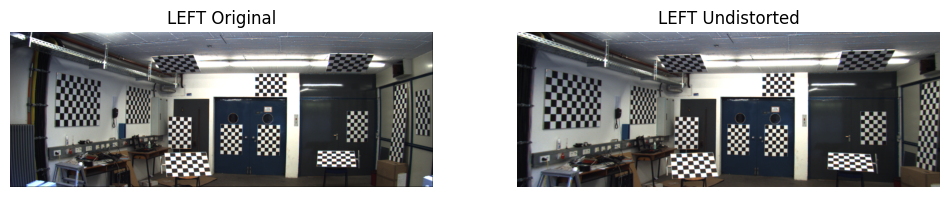

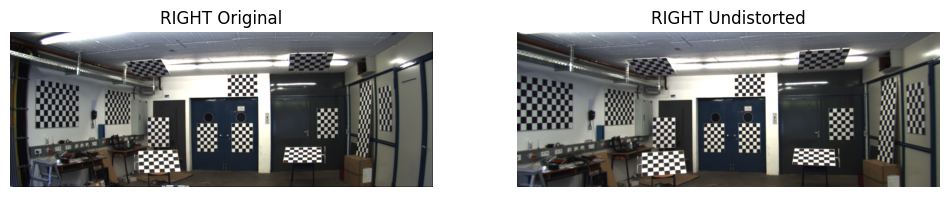

Robust calibration completed for available cameras.
